In [7]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import sympy as sp

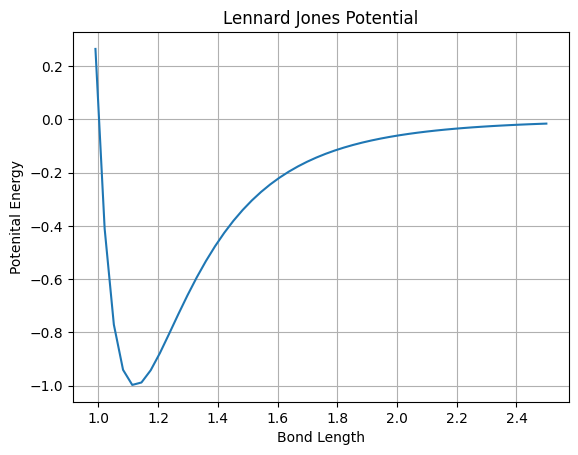

In [5]:
def r_mag(atom_1, atom_2):
    diff_vector =  atom_1 - atom_2
    r = np.linalg.norm(diff_vector)
    return r

def Vlj_3d(r_mag, epsilon=1.0, sigma=1.0):
    potential = 4*epsilon*((sigma/r_mag)**12 - (sigma/r_mag)**6)
    return potential
    
A = np.array([1.0, 0.0, 0.0]) 
B = np.array([0.0, 0.0, 0.0])
atoms = [A, B]
r = r_mag(atoms[0], atoms[1])    
# This here is for a single point, but lets sketch out this potential for mulitple radii
radii = np.linspace(0.99,2.5)
V_E = Vlj_3d(radii)
plt.plot(radii, V_E);plt.xlabel("Bond Length");plt.ylabel("Potenital Energy");plt.title("Lennard Jones Potential");plt.grid()
plt.show()

In [6]:
def Flj_3d(atom_index, atoms, epsilon=1.0, sigma=1.0):
    force = np.zeros((3,1))
    for i in range(len(atoms)):
        if i != atom_index:
            force_part = np.zeros((3,1))
            r = r_mag(atoms[atom_index], atoms[i])
            for j in range(3):
                force_part[j] = ((atoms[atom_index][j] - atoms[i][j]) * ((24*(sigma**6)*epsilon) / (r**8))
                *(1-(2*((sigma/r)**6))))
            force += force_part
    force = -force
        
    return force #Our force is 3 dimensional
    
A = np.array([2.0, 0.0, 0.0]) 
B = np.array([0.0, 0.0, 0.0])
atoms = [A,B]
F = Flj_3d(0, atoms)

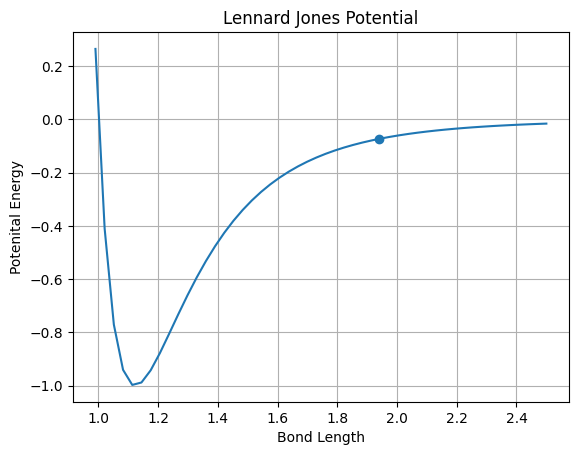

In [14]:
def Verlet_Algorithm(atoms, vel_atoms, m_atoms, end_t, h):
    t = [0]
    x = [[atoms[0][0]], [atoms[1][0]]]#list that keeps track of all the positions of every atoms over the length of time
    y = [[atoms[0][1]], [atoms[1][1]]]
    z = [[atoms[0][2]], [atoms[1][2]]]
    x_vel = [[vel_atoms[0][0]], [vel_atoms[1][0]]]
    y_vel = [[vel_atoms[0][1]], [vel_atoms[1][1]]]
    z_vel = [[vel_atoms[0][2]], [vel_atoms[1][2]]]
    while t[-1] < end_t:    
        # Before we begin, lets find the force at the positions we 
        # curently are and store them for later use
        F_k_0 = np.zeros((len(atoms), 3))
        atoms_new = np.zeros((len(atoms), 3))
        # Step 1: Calculate the new positions
        for i in range(len(atoms)):
            F = Flj_3d(i, atoms)
            #print(F) # GOOD
            for j in range(3):
                F_k_0[i][j] = F[j]
                atoms_new[i][j] = atoms[i][j] + (h*vel_atoms[i][j]) + (((h**2)*F[j])/(2*m_atoms[i]))
            x[i].append(atoms_new[i][0])
            y[i].append(atoms_new[i][1])
            z[i].append(atoms_new[i][2])
        for i in range(len(atoms)): #now we modify 
            for j in range(3):
                atoms[i][j] = atoms_new[i][j]
        # if t[-1] == 0:
        #     print(atoms)
            # print(F_k_0)
        # Step 2: Evaluate the Forces at these new positions
        F_k_1 = np.zeros((len(atoms), 3))
        vel_new = np.zeros((len(atoms), 3))
        # Step 3: Calculate the new velocities 
        for i in range(len(atoms)):
            F = Flj_3d(i, atoms)
            for j in range(3):
                F_k_1[i][j] = F[j]
                # if t[-1] == 0:
                #     print(F_k_1[i][j])
                vel_new[i][j] = vel_atoms[i][j] + ((h/(2*m_atoms[i]))*(F_k_0[i][j]+F_k_1[i][j]))
            # if t[-1] == 0:
            #     print(vel_new)
            x_vel[i].append(vel_new[i][0])
            y_vel[i].append(vel_new[i][1])
            z_vel[i].append(vel_new[i][2])
            # if t[-1] == 0:
            #     print(x_vel[i])
        # if t[-1] == 0:
        #         print(x_vel)
        for i in range(len(atoms)): #now we modify 
            for j in range(3):
                vel_atoms[i][j] = vel_new[i][j]
            # if t[-1] == 0:
            # print(vel_atoms)
        t.append(t[-1]+h)
        
    return t, np.array([x, y, z]), np.array([x_vel, y_vel, z_vel])
A = np.array([2.0, 0.0, 0.0]) 
B = np.array([0.0, 0.0, 0.0])
A_vel = np.array([-0.1, 0.0, 0.0])
B_vel = np.array([0.0, 0.0, 0.0])
atoms = [A,B]
vel_atoms = [A_vel, B_vel]
m_atoms = [1.0, 1.0]
end_t = 10
t, pos, vel = Verlet_Algorithm(atoms, vel_atoms, m_atoms, end_t, 0.02)
r_x = np.sqrt((pos[0][0] - pos[0][1])**2)
r_y = np.sqrt((pos[1][0] - pos[1][1])**2)
V = Vlj_3d(r_x)
energy = (0.5*2*(r_x**2)) + V
#print(pos[0][0][1])
#print(vel[0][1][1])
plt.scatter(r_x[-1], V[-1])
plt.plot(radii, V_E);plt.xlabel("Bond Length");plt.ylabel("Potenital Energy");plt.title("Lennard Jones Potential");plt.grid()
plt.show()

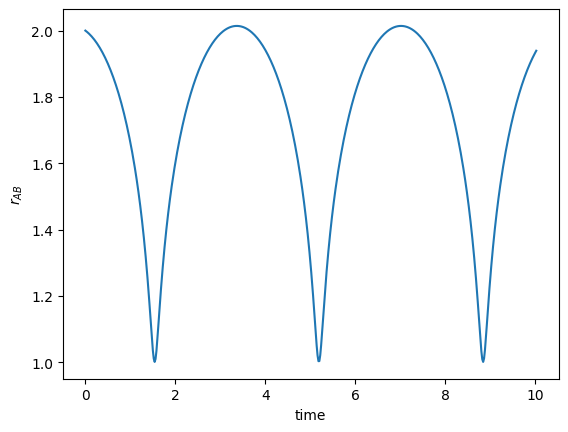

In [15]:
energy = (0.5*2*(r_x**2)) + V
plt.plot(t, r_x);plt.xlabel("time");plt.ylabel("$r_{AB}$");plt.show()

#### Wide at large r because the magnitude of the potential's derivative is smaller than that at small r.

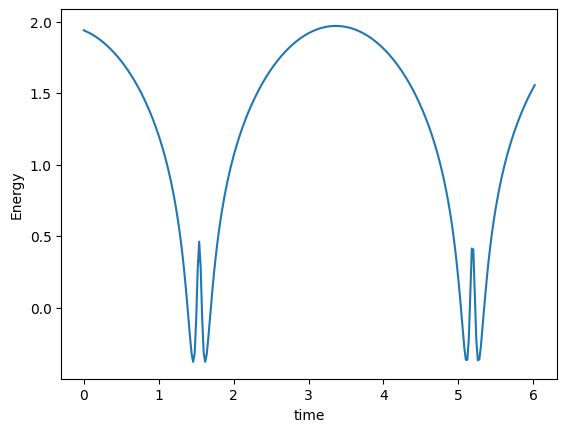

In [13]:
#Energy Conservation
energy = (0.5*1*(r_x**2)) + V
plt.plot(t, energy);plt.xlabel("time");plt.ylabel("Energy") 
plt.show()

#### Error is largest when the radius is small. 